In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras import backend as K

from sklearn import preprocessing

In [5]:
path = "/content/drive/MyDrive/data/lungs_seg_dataset_preprocessed/"
path_id = path + "lists_CovidLungSeg/"

In [6]:
path_train_id = path_id + "covid_lungs_seg_train_list.txt"
f_train = open(path_train_id, "r")

In [7]:
ids = []
for item in f_train:
  item = item.rstrip('\n')
  ids.append(item)

In [8]:
print(len(ids))
f_train.close()

5117


In [9]:
# Set some parameters
reduce_factor = 8 
im_width = 512//reduce_factor
im_height = 512//reduce_factor
border = 5

In [10]:
## checking compatibility
file_path = path + "images_bcet/" + ids[0]
img = np.load(file_path)
x_img = img
x_img = x_img + abs(x_img.min())
x_img = x_img/x_img.max()

In [11]:
x_img.shape

(512, 512)

In [12]:
img_resized = resize(img, (im_height, im_width), anti_aliasing=True)

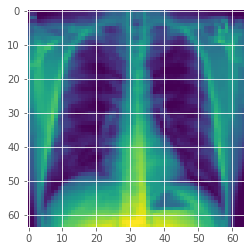

In [13]:
plt.imshow(img_resized)

In [40]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

**Load the images and masks into arrays**

In [46]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    file_path = path + "images_bcet/" + id_
    img = np.load(file_path)
    x_img = img
    x_img = x_img + abs(x_img.min())
    x_img = x_img/x_img.max()
    x_img = resize(x_img, (im_height, im_width, 1), anti_aliasing=True)

    # Load masks
    mask_path = path + "masks_resized/" + id_
    mask = np.load(mask_path)
    mask = mask + abs(mask.min())
    mask = mask/mask.max()
    mask = resize(mask, (im_height, im_width, 1), anti_aliasing=True)

    X[n] = x_img
    y[n] = mask

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [92]:
XX, yy = X, y

In [39]:
y.shape

(5117, 64, 64, 1)

In [56]:
## validation set 
path_validation_id = path_id + "covid_lungs_seg_val_list.txt"
f_validation = open(path_validation_id, "r")

ids_val = []
for item in f_validation:
  item = item.rstrip('\n')
  ids_val.append(item)

X_val = np.zeros((len(ids_val), im_height, im_width, 1), dtype=np.float32)
y_val = np.zeros((len(ids_val), im_height, im_width, 1), dtype=np.float32)

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids_val), total=len(ids_val)):
    file_path = path + "images_bcet/" + id_
    img = np.load(file_path)
    x_img = img
    x_img = x_img + abs(x_img.min())
    x_img = x_img/x_img.max()
    x_img = resize(x_img, (im_height, im_width, 1), anti_aliasing=True)


    # Load masks
    mask_path = path + "masks_resized/" + id_
    mask = np.load(mask_path)
    mask = mask + abs(mask.min())
    mask = mask/mask.max()
    mask = resize(mask, (im_height, im_width, 1), anti_aliasing=True)

    X_val[n] = x_img
    y_val[n] = mask

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [17]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [103]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)
def my_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [104]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [109]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss=my_loss, metrics=[dice_coef])

In [111]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('main.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [112]:
results = model.fit(X, y, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_val, y_val))

Epoch 1/50
160/160 [==============================] - 173s 1s/step - loss: 0.2472 - dice_coef: 0.7528 - val_loss: 0.1572 - val_dice_coef: 0.8428

Epoch 00001: val_loss improved from inf to 0.15722, saving model to model_unet.h5
Epoch 2/50
160/160 [==============================] - 171s 1s/step - loss: 0.0893 - dice_coef: 0.9107 - val_loss: 0.0879 - val_dice_coef: 0.9121

Epoch 00002: val_loss improved from 0.15722 to 0.08789, saving model to model_unet.h5
Epoch 3/50
160/160 [==============================] - 173s 1s/step - loss: 0.0740 - dice_coef: 0.9260 - val_loss: 0.0719 - val_dice_coef: 0.9281

Epoch 00003: val_loss improved from 0.08789 to 0.07190, saving model to model_unet.h5
Epoch 4/50
160/160 [==============================] - 172s 1s/step - loss: 0.0685 - dice_coef: 0.9315 - val_loss: 0.0664 - val_dice_coef: 0.9336

Epoch 00004: val_loss improved from 0.07190 to 0.06642, saving model to model_unet.h5
Epoch 5/50
160/160 [==============================] - 171s 1s/step - loss: 0

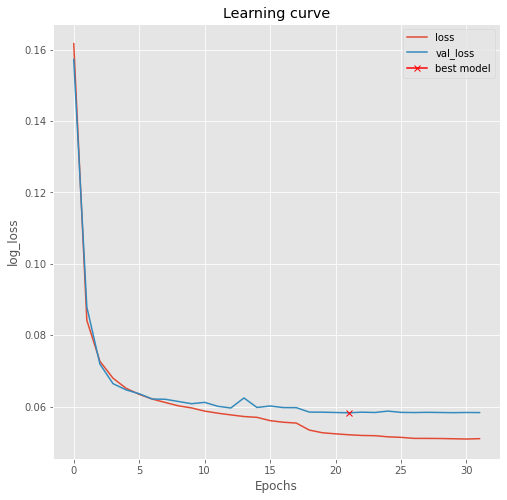

In [113]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

**Inference**

In [136]:
# load the best model
model.load_weights('main.h5')

In [137]:
model.evaluate(X_val, y_val, verbose=1)

20/20 [==============================] - 5s 229ms/step - loss: 0.0632 - dice_coef: 0.9368


[0.06317699700593948, 0.9368304014205933]

In [138]:
## testing set 
path_test_id = path_id + "covid_lungs_seg_test_list.txt"
f_test = open(path_test_id, "r")

ids_test = []
for item in f_test:
  item = item.rstrip('\n')
  ids_test.append(item)

X_test = np.zeros((len(ids_test), im_height, im_width, 1), dtype=np.float32)
y_test = np.zeros((len(ids_test), im_height, im_width, 1), dtype=np.float32)

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids_test), total=len(ids_test)):
    # Load images
    file_path = path + "images_bcet/" + id_
    img = np.load(file_path)
    x_img = img
    x_img = x_img + abs(x_img.min())
    x_img = x_img/x_img.max()
    x_img = resize(x_img, (im_height, im_width, 1), anti_aliasing=True)

    # Load masks
    mask_path = path + "masks_resized/" + id_
    mask = np.load(mask_path)
    #mask = img_to_array(mask)
    mask = mask + abs(mask.min())
    mask = mask/mask.max()
    mask = resize(mask, (im_height, im_width, 1), anti_aliasing=True)

    X_test[n] = x_img
    y_test[n] = mask

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [139]:
X_test.shape

(639, 64, 64, 1)

In [140]:
# Predict on train, val and test
preds_train = model.predict(X, verbose=1)
preds_val = model.predict(X_val, verbose=1)

20/20 [==============================] - 5s 231ms/step


In [141]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [143]:
# Predict on train, val and test
preds_train = model.predict(X, verbose=1)
preds_val = model.predict(X_val, verbose=1)
preds_test = model.predict(X_test, verbose=1)

20/20 [==============================] - 5s 228ms/step


In [185]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Lungs')

    ax[1].imshow(y[ix].squeeze() )
    ax[1].set_title('Ground Truth')

    ax[2].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted binary');

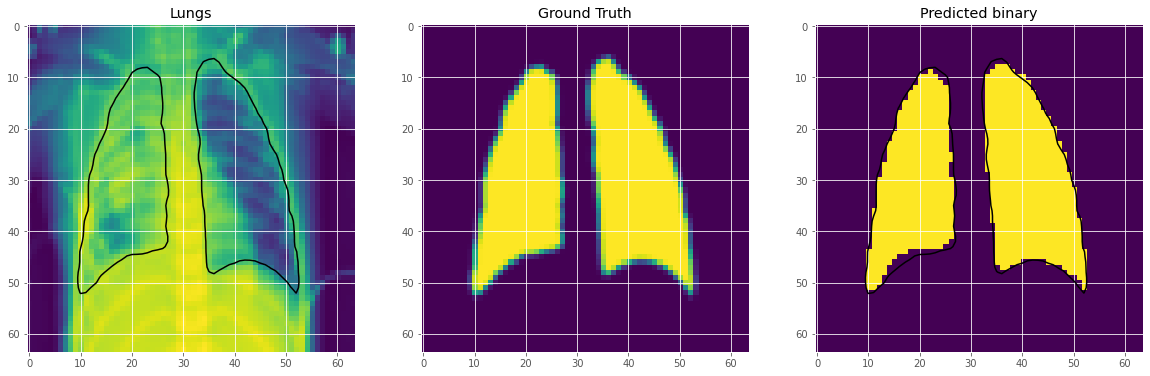

In [186]:
plot_sample(X, y, preds_train, preds_train_t)

**Qualitative Testing**

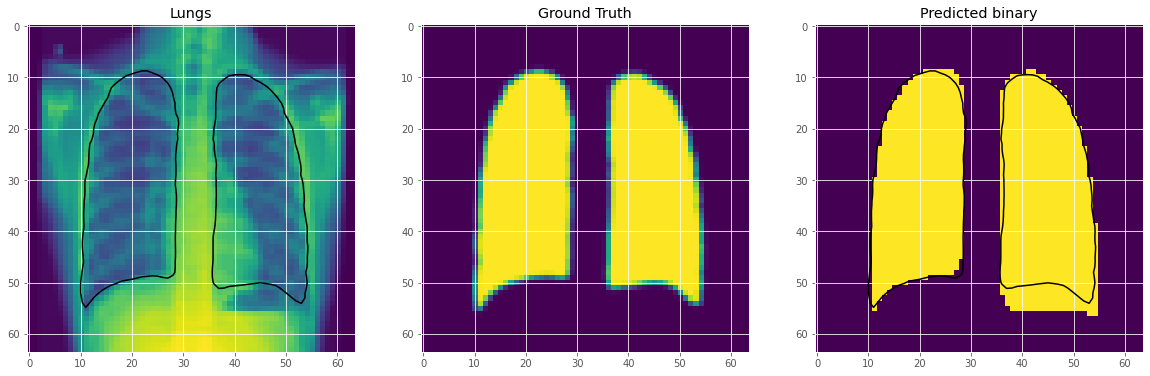

In [187]:
plot_sample(X_test, y_test, preds_test, preds_test_t)

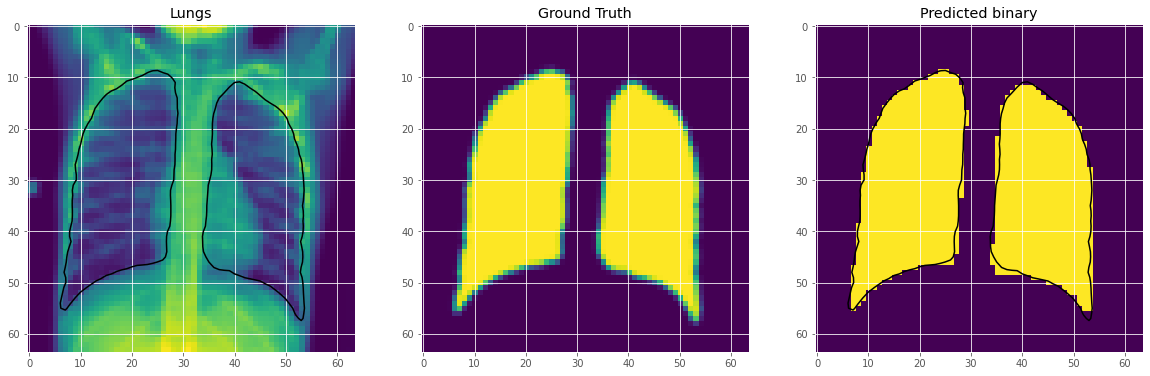

In [169]:
plot_sample(X_test, y_test, preds_test, preds_test_t)

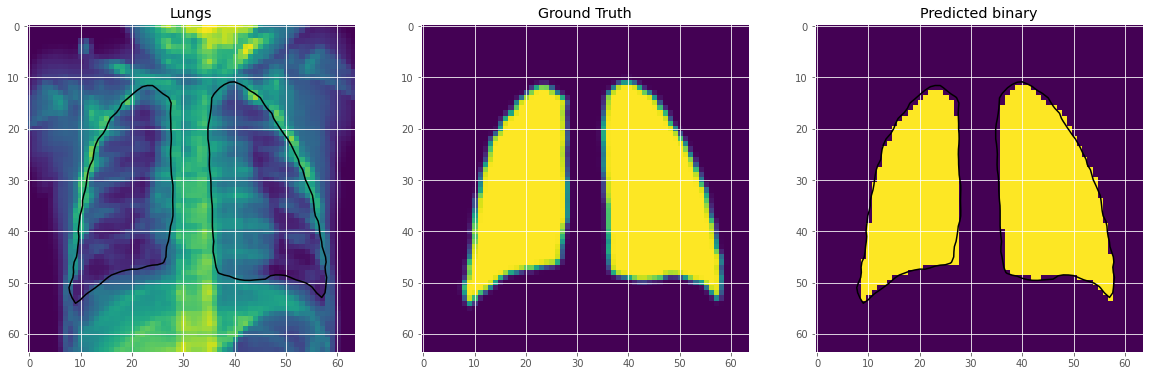

In [170]:
plot_sample(X_test, y_test, preds_test, preds_test_t)

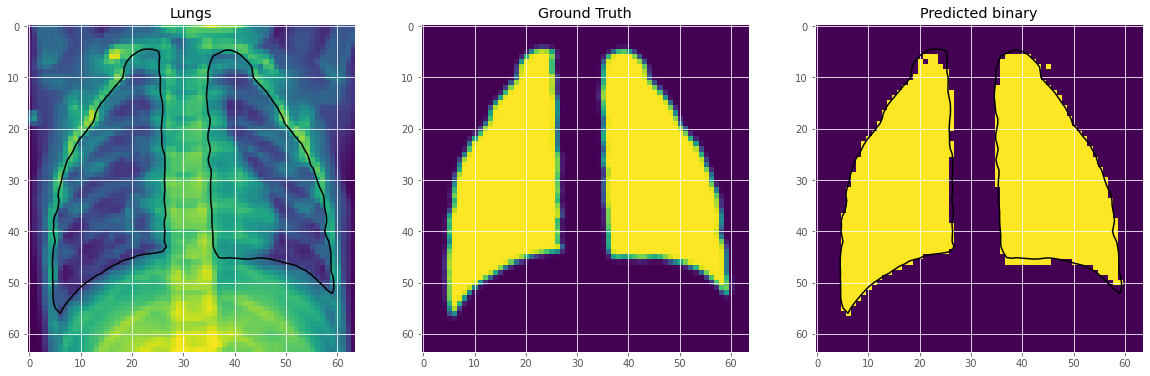

In [171]:
plot_sample(X_test, y_test, preds_test, preds_test_t)